In [1]:
from utils_DS_luis import history_treatment
# from utils_DS_luis import transform_data
# from utils_DS_luis import plot_correlation

import tensorflow as tf 
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pickle import dump, load 

#### **DATA ANALYSIS** ####

***
The study proposed here is applied to the saturated scenario considering the following features:  
* Height - meters  
* Inclination - degrees 
* Cohesion - kPa
* Friction angle - degrees
* Specific weight - kN/m³
* Safety factor 
***

In [2]:
file = 'new_database_slopes.txt'
data = pd.read_csv(file)
data.columns = ['Model', 'Height','Inclination', 'Cohesion',
                'Friction_angle', 'Specific_weight', 'Safety_factor']
data.drop('Model', axis=1, inplace=True)

# ONLY USING DATA WITH FS < 10!
data = data[data['Safety_factor'] < 10]

In [3]:
data.describe()

,Height,Inclination,Cohesion,Friction_angle,Specific_weight,Safety_factor
count,956.000000,956.000000,956.000000,956.000000,956.000000,956.000000
mean,104.789753,32.800486,147.094142,24.712814,20.035690,2.484278
std,55.432174,15.613362,86.396611,14.403193,5.811989,2.049359
min,2.693000,5.082500,0.150000,0.025000,10.010000,0.041275
25%,57.489500,19.423750,72.375000,12.312500,14.965000,1.038815
50%,105.158000,32.775000,145.800000,24.450000,20.100000,1.793147
75%,152.628500,46.291250,221.025000,37.137500,25.115000,3.255111
max,199.901000,59.972500,299.850000,49.975000,29.990000,9.937383


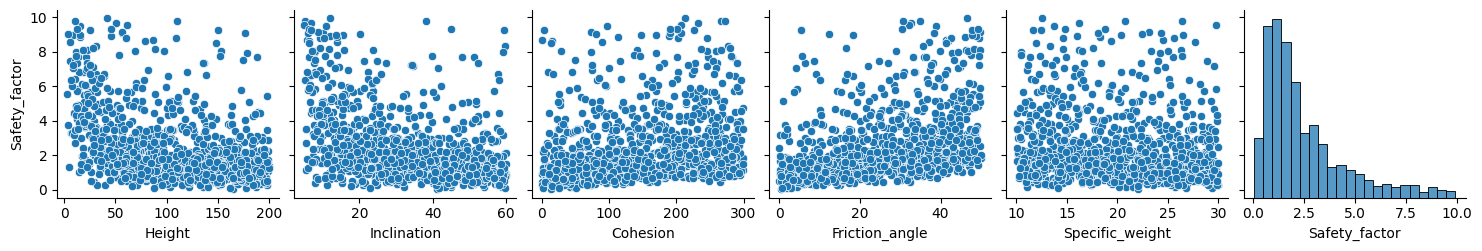

In [4]:
sns.pairplot(data, y_vars='Safety_factor')

<Axes: >

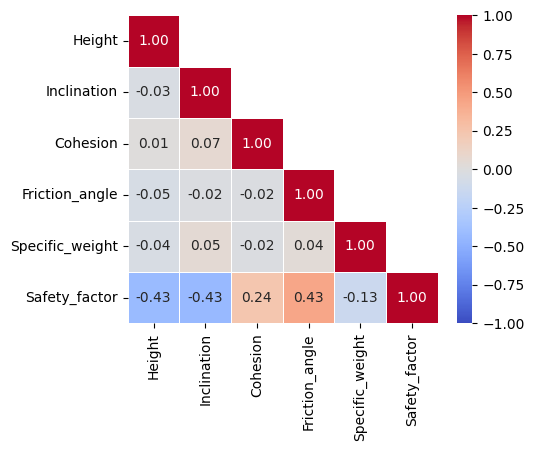

In [4]:
correlation = data.corr()

mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True

# Want diagonal elements as well
mask[np.diag_indices_from(mask)] = False

plt.figure(figsize=(5,4))
plot = sns.heatmap(correlation, mask=mask, vmin=-1, cmap= 'coolwarm',
                   annot = True, fmt=".2f", linewidths=.6)
plt.xticks(rotation = 90)
plot

***
A priori:
* Não é possível observar padrões/correlações muito altas e claras entre as variáveis
de entrada e o fator de segurança.   

* É possível observar um desbalanceamento na distribuição dos valores dos fatores de
segurança. 
***

##### **Thinking on safety factor distribution**

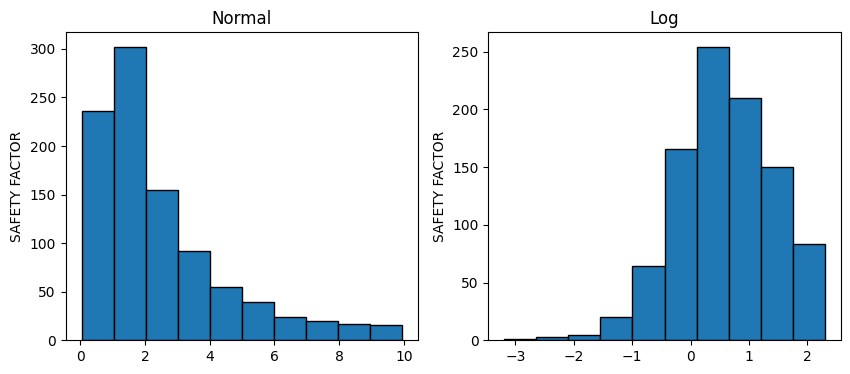

In [5]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(10)
ax[0].hist(data=data, x='Safety_factor', edgecolor = 'k')
ax[1].hist(data=np.log(data), x='Safety_factor', edgecolor = 'k')
ax[0].set_ylabel('Frequency')
ax[1].set_ylabel('Frequency')
ax[0].set_ylabel('SAFETY FACTOR')
ax[1].set_ylabel('SAFETY FACTOR')
ax[1].set_title('Log')
ax[0].set_title('Normal')
plt.show()

***
Considerando que a transformação da variável - *FS' = log(FS)* - apresenta uma distribuição
mais próxima a uma distribuição normal, eu optei por usar a variável transformada. Dessa forma, 
o dataset fica mais balanceado fazendo assim que o modelo preditivo se torne mais eficiente. 
  
* É importante destacar que todas as métricas avaliadas doravante consideram a variável, ou seja:  
**FS = exp(FS')**
***

In [6]:
data['Safety_factor'] = np.log(data['Safety_factor'])
data.describe()

,Height,Inclination,Cohesion,Friction_angle,Specific_weight,Safety_factor
count,956.000000,956.000000,956.000000,956.000000,956.000000,956.000000
mean,104.789753,32.800486,147.094142,24.712814,20.035690,0.590890
std,55.432174,15.613362,86.396611,14.403193,5.811989,0.832208
min,2.693000,5.082500,0.150000,0.025000,10.010000,-3.187501
25%,57.489500,19.423750,72.375000,12.312500,14.965000,0.038078
50%,105.158000,32.775000,145.800000,24.450000,20.100000,0.583972
75%,152.628500,46.291250,221.025000,37.137500,25.115000,1.180226
max,199.901000,59.972500,299.850000,49.975000,29.990000,2.296304


<Figure size 640x480 with 0 Axes>

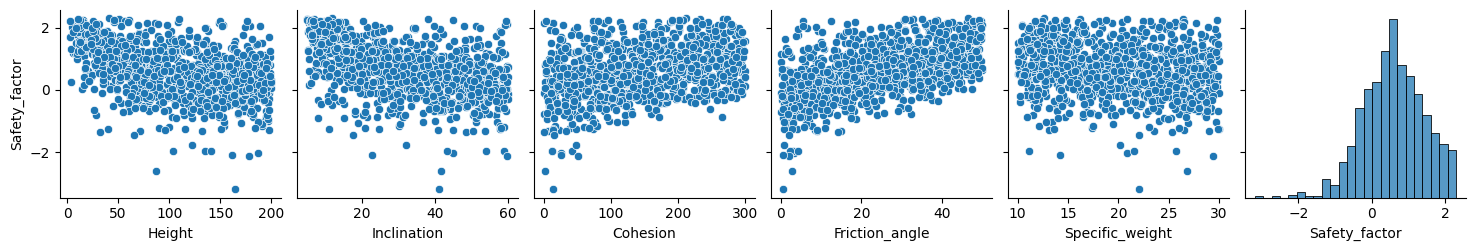

In [7]:
plt.figure()
_ = sns.pairplot(data=data, diag_kind="hist", y_vars='Safety_factor')


***
Quando feito o pair plot do considerando os dados de entrada é possivel observar padrões suaves de comportamento.  

**É possivel observar tendências suaves (ou muito suaves):**

* Correlação negativa do FS* com H
* Correlação negativa do FS* com a inclinação 
* Correlação positiva do FS* com a coesão
* Correlação positiva do FS* com o ângulo de atrito
* Correlação nenhuma do FS* com o peso específico

Os resultados obtidos visualmente são confirmados pela matriz de correlação a seguir.
***


<Axes: >

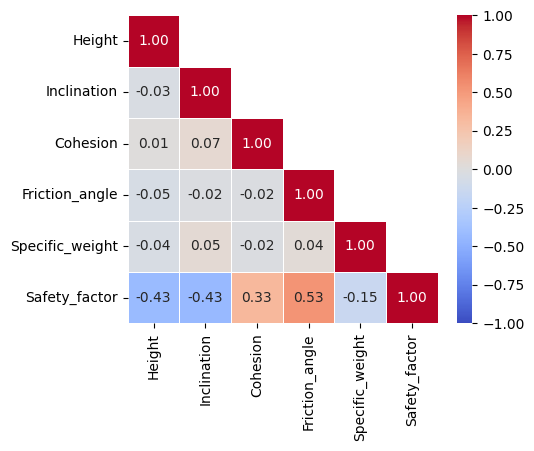

In [8]:
correlation = data.corr()

mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True

# Want diagonal elements as well
mask[np.diag_indices_from(mask)] = False

plt.figure(figsize=(5,4))
plot = sns.heatmap(correlation, mask=mask, vmin=-1, cmap= 'coolwarm',
                   annot = True, fmt=".2f", linewidths=.6)
plt.xticks(rotation = 90)
plot

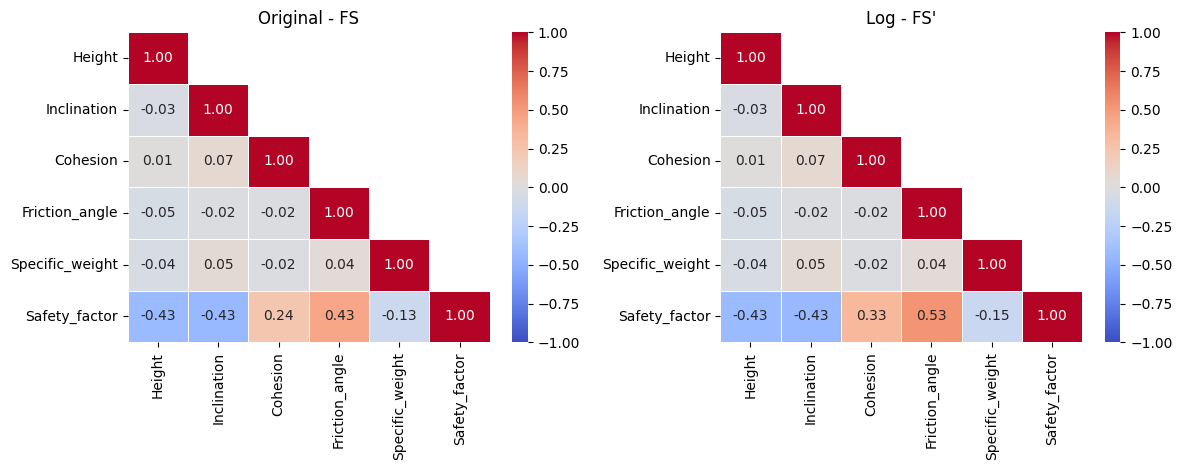

In [9]:
data_log = data.copy()
data_ori = data.copy()
data_ori['Safety_factor'] = np.exp(data['Safety_factor'])

log_correlation = data_log.corr()
ori_correlation = data_ori.corr()

mask = np.zeros_like(log_correlation)
mask[np.triu_indices_from(mask)] = True

# Want diagonal elements as well
mask[np.diag_indices_from(mask)] = False


fig, ax = plt.subplots(1,2) 
fig.set_figwidth(12)
sns.heatmap(log_correlation, mask=mask, vmin=-1, cmap= 'coolwarm',
            annot = True, fmt=".2f", linewidths=.6, ax=ax[1])

sns.heatmap(ori_correlation, mask=mask, vmin=-1, cmap= 'coolwarm',
            annot = True, fmt=".2f", linewidths=.6, ax=ax[0])

ax[0].set_title('Original - FS')
ax[1].set_title("Log - FS'")

plt.tight_layout()

***
Sobre correlação de pearson para dados transformado e convencionais:

* Dessa forma é possível observar que todas as features de entrada apresentam 
correlação (Pearson correlation) maior com o SF transformado pelo ***log***. 
***

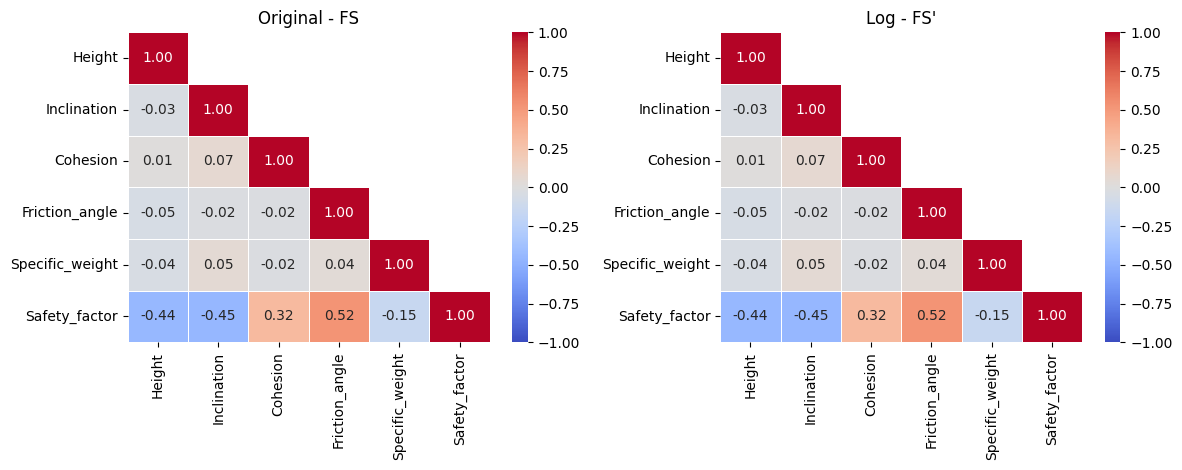

In [10]:
data_log = data.copy()
data_ori = data.copy()
data_ori['Safety_factor'] = np.exp(data['Safety_factor'])

log_correlation = data_log.corr(method='spearman')
ori_correlation = data_ori.corr(method='spearman')

mask = np.zeros_like(log_correlation)
mask[np.triu_indices_from(mask)] = True

# Want diagonal elements as well
mask[np.diag_indices_from(mask)] = False


fig, ax = plt.subplots(1,2) 
fig.set_figwidth(12)
sns.heatmap(log_correlation, mask=mask, vmin=-1, cmap= 'coolwarm',
            annot = True, fmt=".2f", linewidths=.6, ax=ax[1])

sns.heatmap(ori_correlation, mask=mask, vmin=-1, cmap= 'coolwarm',
            annot = True, fmt=".2f", linewidths=.6, ax=ax[0])

ax[0].set_title('Original - FS')
ax[1].set_title("Log - FS'")

plt.tight_layout()

***
Sobre a correção de **Spearman**: 

* Correlação de Spearman (ñ linear) é insensível a transformação. 

* Coeficientes de Spearman são superiores a Pearson (correlação é não linear)

* Veja para entender SPEARMAN: 
    * https://pt.wikipedia.org/wiki/Ficheiro:Spearman_fig1.svg

***

##### **Data splitting**

In [11]:
file = 'new_database_slopes.txt'
data = pd.read_csv(file)
data.columns = ['Model', 'Height','Inclination', 'Cohesion',
                'Friction_angle', 'Specific_weight', 'Safety_factor']
data.drop('Model', axis=1, inplace=True)

# ONLY USING DATA WITH FS < 10!
data = data[data['Safety_factor'] < 10]
data['Safety_factor'] = np.log(data['Safety_factor'])

In [12]:
inp_columns = ['Height', 'Inclination', 'Cohesion', 'Friction_angle', 'Specific_weight']
out_column = ['Safety_factor']

# Scalers:
inp_scaler = StandardScaler()
out_scaler = StandardScaler()


x_train, x_test, y_train, y_test = train_test_split(data[inp_columns], 
                                                    data[out_column],
                                                    test_size = 0.2,
                                                    random_state = 0)

x_train_norm = inp_scaler.fit_transform(x_train)
x_test_norm = inp_scaler.transform(x_test)

y_train_norm = out_scaler.fit_transform(y_train)
y_test_norm = out_scaler.transform(y_test)

print('Train size:')
print(x_train_norm.shape)
print(y_train_norm.shape)
print('Test size:')
print(x_test_norm.shape)
print(y_test_norm.shape)

Train size:
(764, 5)
(764, 1)
Test size:
(192, 5)
(192, 1)


In [13]:
print(80*'*')
print('Training - inputs')
descritive_frame = pd.DataFrame(x_train, columns=inp_columns).describe()
print(descritive_frame.loc[['mean', 'std', 'min', 'max'], :].T.round(2))
print(80*'*')
print('Test - inputs')
descritive_frame = pd.DataFrame(x_test, columns=inp_columns).describe()
print(descritive_frame.loc[['mean', 'std', 'min', 'max'], :].T.round(2))
print(80*'*')

print('Training - target')
descritive_frame = pd.DataFrame(y_train).describe()
print(descritive_frame.loc[['mean', 'std', 'min', 'max'], :].T.round(2))
print(80*'*')
print('Test - target')
descritive_frame = pd.DataFrame(y_test).describe()
print(descritive_frame.loc[['mean', 'std', 'min', 'max'], :].T.round(2))
print(80*'*')

********************************************************************************
Training - inputs
                   mean    std    min     max
Height           104.79  55.66   2.69  199.70
Inclination       33.31  15.59   5.08   59.97
Cohesion         147.92  85.22   0.15  299.85
Friction_angle    24.48  14.38   0.08   49.92
Specific_weight   19.91   5.77  10.03   29.99
********************************************************************************
Test - inputs
                   mean    std    min     max
Height           104.78  54.65   3.48  199.90
Inclination       30.78  15.57   5.47   59.70
Cohesion         143.83  91.09   2.85  299.25
Friction_angle    25.64  14.48   0.02   49.98
Specific_weight   20.52   5.96  10.01   29.85
********************************************************************************
Training - target
               mean   std   min  max
Safety_factor  0.58  0.84 -3.19  2.3
********************************************************************************


In [57]:
# Saving scalers for the future: 
dump(inp_scaler, open('input_scaler_log.save', 'wb'))
dump(out_scaler, open('output_scaler_log.save', 'wb'))

#### **Parametric analysis of hyperparameters**

***
Parametrical investigation of the hyperparameters:

* Number of hidden layers 

* Number of neurons per layer

* **PS. The mean of five simulations per set of params is considered**

* **PS. The number of epochs found by early stopping is also saved**
***

In [131]:
neurons_space = [32, 64, 128, 256, 512]
hidden_layers_space = [1, 2, 3, 4, 5]
results = {}
for neurons in neurons_space: 
    for hidden_layers in hidden_layers_space: 
        for iter in range(5): 
            print('-----------------------------------')
            print(f'iter = {iter} // hidden_layers = {hidden_layers} // neurons = {neurons}')
            lr = 0.0001
            activation = 'tanh'
            
            model = tf.keras.models.Sequential()    
            model.add(tf.keras.layers.Dense(neurons, input_dim=x_train.shape[1]))

            for i in range(hidden_layers-1):
                name = 'layer_dense_{0}'.format(i+1)
                model.add(tf.keras.layers.Dense(neurons, activation=activation,
                                                name=name))
                
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

            model.add(tf.keras.layers.Dense(1, activation='linear'))

            model.compile(optimizer=optimizer,
                          loss='mse',
                          metrics=['mae', 'mape'])
            
            early_stop = tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True,
                                                          start_from_epoch=100)

            history = model.fit(x_train_norm, y_train_norm, epochs = 500, 
                                validation_split=0.1, 
                                callbacks=[early_stop],
                                batch_size=32, verbose=0)
            
            epocs = model.history.epoch[-1]
            mse  = round(model.history.history['val_loss'][-1], 4)
            mape = round(model.history.history['val_mape'][-1], 4)
            print(f'MSE = {mse} / MAPE = {mape} / EPOCS = {epocs}')
            results[f'{iter}-{hidden_layers}-{neurons}-{epocs}'] = [mse, mape, epocs]

-----------------------------------
iter = 0 // hidden_layers = 1 // neurons = 32
MSE = 0.1631 / MAPE = 211.4703 / EPOCS = 174
-----------------------------------
iter = 1 // hidden_layers = 1 // neurons = 32
MSE = 0.1632 / MAPE = 211.3139 / EPOCS = 150
-----------------------------------
iter = 2 // hidden_layers = 1 // neurons = 32
MSE = 0.163 / MAPE = 211.4419 / EPOCS = 170
-----------------------------------
iter = 3 // hidden_layers = 1 // neurons = 32
MSE = 0.1633 / MAPE = 210.7079 / EPOCS = 201
-----------------------------------
iter = 4 // hidden_layers = 1 // neurons = 32
MSE = 0.1631 / MAPE = 209.5114 / EPOCS = 213
-----------------------------------
iter = 0 // hidden_layers = 2 // neurons = 32
MSE = 0.0355 / MAPE = 73.3115 / EPOCS = 499
-----------------------------------
iter = 1 // hidden_layers = 2 // neurons = 32
MSE = 0.0357 / MAPE = 88.4291 / EPOCS = 499
-----------------------------------
iter = 2 // hidden_layers = 2 // neurons = 32
MSE = 0.0362 / MAPE = 90.1986 / 

In [209]:
dump(results, open('results_log_optimization_in_grid.save', 'wb'))

In [213]:
results_frame = pd.DataFrame(results).T   

results_frame.columns = ['mse', 'mape', 'epocs']
results_frame.drop('epocs', axis=1, inplace=True)

results_frame[['iter', 'layers', 'neurons', 'epochs']] = list(results_frame.index.str.split('-'))

results_frame['id_'] = results_frame['layers'] + '-' + results_frame['neurons']

results_frame['layers'] = results_frame['layers'].astype(int)
results_frame['neurons'] = results_frame['neurons'].astype(int)
results_frame['epochs'] = results_frame['epochs'].astype(int)


results_frame = results_frame.groupby(by='id_').mean()

results_frame.sort_values(by=['neurons', 'layers'], inplace=True)
results_frame.reset_index(inplace=True)
results_frame

,id_,mse,mape,iter,layers,neurons,epochs
0,1-32,0.16314,210.88908,246.8,1.0,32.0,181.6
1,2-32,0.03540,88.80150,246.8,2.0,32.0,499.0
2,3-32,0.01978,66.04412,246.8,3.0,32.0,499.0
3,4-32,0.01374,42.68136,246.8,4.0,32.0,499.0
4,5-32,0.01158,40.31990,246.8,5.0,32.0,499.0
5,1-64,0.16296,211.02018,246.8,1.0,64.0,195.6
6,2-64,0.02830,68.28592,246.8,2.0,64.0,499.0
7,3-64,0.01524,51.63710,246.8,3.0,64.0,499.0
8,4-64,0.00704,31.34946,246.8,4.0,64.0,499.0
9,5-64,0.00530,28.77610,246.8,5.0,64.0,499.0


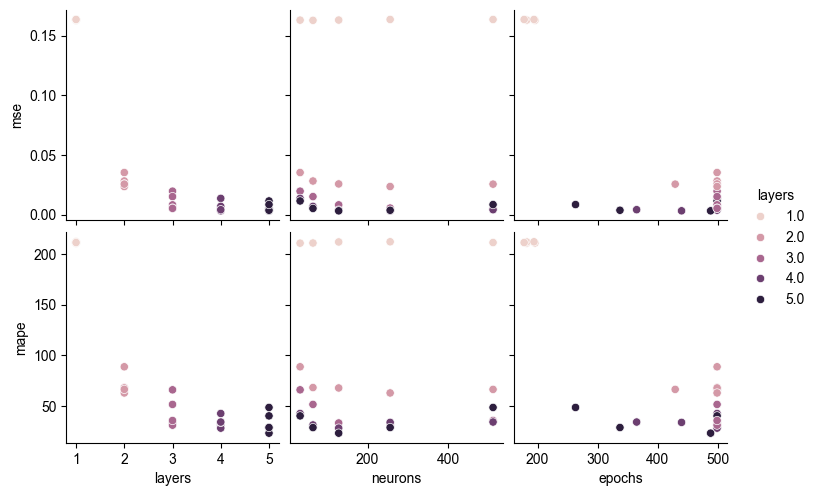

In [207]:
sns.pairplot(data=results_frame.drop('id_', axis=1),
             y_vars=['mse', 'mape'],
             x_vars=['neurons', 'epochs'],
             hue='layers')

In [191]:
results_frame.groupby(by='id_', ).mean()

,mse,mape,iter,layers,neurons,epochs
id_,,,,,,
1-128,0.16320,212.06572,246.8,1.0,128.0,181.8
1-256,0.16370,212.24058,246.8,1.0,256.0,194.0
1-32,0.16314,210.88908,246.8,1.0,32.0,181.6
1-512,0.16368,211.48592,246.8,1.0,512.0,177.6
1-64,0.16296,211.02018,246.8,1.0,64.0,195.6
2-128,0.02584,67.87934,246.8,2.0,128.0,499.0
2-256,0.02368,62.96076,246.8,2.0,256.0,499.0
2-32,0.03540,88.80150,246.8,2.0,32.0,499.0
2-512,0.02568,66.47088,246.8,2.0,512.0,429.2


In [214]:
results_frame.to_excel('results_log_optimization_in_grid.xlsx')

Go to excel to see the main findings!            


* ***C:\Users\luissantos\Desktop\try_cuda\IEEA_experimento2\results_log_optimization_in_grid.xlsx***

#### **First training metrics -> Non-important for while**

24/24 [==============================] - 0s 782us/step
R² = 0.971 // RMSE = 0.166 // MAPE = 7.112%
6/6 [==============================] - 0s 1ms/step
R² = 0.938 // RMSE = 0.349 // MAPE = 9.468%


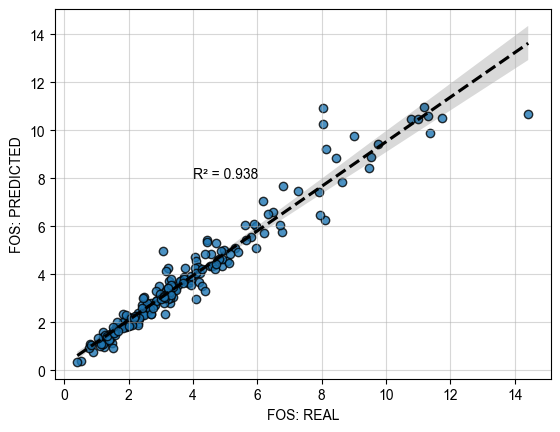

In [80]:
y_pred_train = np.exp(out_scaler.inverse_transform(model.predict(x_train)))
y_real_train = np.exp(out_scaler.inverse_transform(y_train))

r2         = r2_score(y_pred_train, y_real_train)
rmse       = mean_squared_error(y_pred_train, y_real_train)
mape       = mean_absolute_percentage_error(y_pred_train.flatten(), y_real_train.flatten())*100

print(f'R² = {r2.round(3)} // RMSE = {rmse.round(3)} // MAPE = {mape.round(3)}%')

y_pred_teste = np.exp(out_scaler.inverse_transform(model.predict(x_test)))
y_real_teste = np.exp(out_scaler.inverse_transform(y_test))

r2         = r2_score(y_real_teste, y_pred_teste)
rmse       = mean_squared_error(y_real_teste, y_pred_teste)
mape       = mean_absolute_percentage_error(y_real_teste.flatten(), y_pred_teste.flatten())*100

print(f'R² = {r2.round(3)} // RMSE = {rmse.round(3)} // MAPE = {mape.round(3)}%')

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
sns.regplot(x = y_pred_teste,
            y = y_real_teste,
            scatter_kws={'edgecolor':'k'}, line_kws={'linestyle':'--', 'color':'k'})

plt.xlabel('FOS: REAL')
plt.ylabel('FOS: PREDICTED')
plt.text(4, 8, f'R² = {r2.round(4)}')
plt.grid(alpha = 0.5)

## **Anexos**

#### **INICIO DA OTIMIZAÇÃO BAYESIANA USANDO ANN:**

In [59]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations

# Supress NaN warnings, see: https://stackoverflow.com/questions/34955158/what-might-be-the-cause-of-invalid-value-encountered-in-less-equal-in-numpy
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)


def cross_validation(learning_rate, num_dense_layers, num_dense_nodes, num_activation, bs=32):
    print('########################### Nova Chamada ###########################')
    kf = KFold(n_splits=10)
    fold = 0
    mse  = []
    callback1 = tf.keras.callbacks.EarlyStopping(monitor='val_mse', 
                                                 patience=50, 
                                                 restore_best_weights= False, 
                                                 start_from_epoch=100)

    for train_id, test_id in kf.split(x_train, y_train):
        fold += 1
        model = create_model(learning_rate, num_dense_layers,
                             num_dense_nodes, num_activation,)  
         
        model.fit(x_train[train_id], y_train[train_id], verbose = 0,
                  validation_split = 0.1, callbacks = [callback1], 
                  batch_size = bs, epochs=1000)
        
        #Predict
        yp = np.exp(out_scaler.inverse_transform(model.predict(x_train[test_id], verbose = 0)))
        #Expected
        yv = np.exp(out_scaler.inverse_transform(y_train[test_id]))
        #Expected
        rmse = mean_squared_error(yv, yp)
        mse.append(rmse)

        print(f'Fold - {fold} - MSE = {rmse}')

    return np.mean(mse)
        
def fitness(dimensions):  
    learning_rate    = dimensions[0]
    num_dense_layers = dimensions[1]
    num_dense_nodes  = dimensions[2]
    num_activation   = dimensions[3]
                            
    mse   = cross_validation(learning_rate, num_dense_layers,num_dense_nodes, num_activation, 32)

    print(f'lr - {learning_rate} - HL = {num_dense_layers} - NN = {num_dense_nodes}')
    print(f'act = {num_activation}')
    print(f'MSE - mean_folds = {mse}')

    return mse
   
def create_model(learning_rate, num_dense_layers, num_dense_nodes, activation): 

    act_func = activation

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.models.Sequential()    

    model.add(tf.keras.layers.Dense(num_dense_nodes, 
                                    input_dim = x_train.shape[1], 
                                    activation=act_func))

    for i in range(num_dense_layers-1):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(tf.keras.layers.Dense(num_dense_nodes, activation=act_func,
                                        name=name))
        
    model.add(tf.keras.layers.Dense(y_train.shape[1],
                                    activation='linear'))

    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae','mse'])
                  
    return model


In [125]:
dim_learning_rate       = Real(low=1e-5, high=1e-2)
dim_num_dense_layers    = Integer(low=1, high=5)
dim_num_dense_nodes     = Integer(low=50, high=500)
dim_activation          = Categorical(['relu','swish','tanh'])

dimensions              = [dim_learning_rate, 
                           dim_num_dense_layers, 
                           dim_num_dense_nodes,
                           dim_activation]

# Optimization: 
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            initial_point_generator='lhs',
                            n_initial_points=10,
                            n_jobs=4, 
                            n_calls = 100)

# 333m 52.7s

########################### Nova Chamada ###########################
Fold - 1 - MSE = 0.2348410401032271
Fold - 2 - MSE = 0.09544498705114243
Fold - 3 - MSE = 0.12334289786005358
Fold - 4 - MSE = 0.0593142834089521
Fold - 5 - MSE = 0.06143628233630414
Fold - 6 - MSE = 0.05025491493172083
Fold - 7 - MSE = 0.1580441513791961
Fold - 8 - MSE = 0.28312955439283943
Fold - 9 - MSE = 0.13721961346150124
Fold - 10 - MSE = 0.04698224295354941
lr - 0.008477202881968769 - HL = 3 - NN = 57
act = tanh
MSE - mean_folds = 0.12500099678784865
########################### Nova Chamada ###########################
Fold - 1 - MSE = 0.19570319887996945
Fold - 2 - MSE = 0.09717149313148984
Fold - 3 - MSE = 0.14843715329198437
Fold - 4 - MSE = 0.05539156305213404
Fold - 5 - MSE = 0.10316848536584354
Fold - 6 - MSE = 0.06123530049104436
Fold - 7 - MSE = 0.1976063668552685
Fold - 8 - MSE = 0.27774543593300954
Fold - 9 - MSE = 0.07795500367790373
Fold - 10 - MSE = 0.09310521291826783
lr - 0.0034467418152943252 - 

c:\Users\luissantos\AppData\Local\Programs\Python\Python38\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


########################### Nova Chamada ###########################
Fold - 1 - MSE = 0.057351939521725084
Fold - 2 - MSE = 0.07849537226952309
Fold - 3 - MSE = 0.08141162143216865
Fold - 4 - MSE = 0.04805538463964865
Fold - 5 - MSE = 0.03235421405004803
Fold - 6 - MSE = 0.05329204891496746
Fold - 7 - MSE = 0.0981852891762563
Fold - 8 - MSE = 0.2593375297356972
Fold - 9 - MSE = 0.07228735957450971
Fold - 10 - MSE = 0.043981918042613116
lr - 0.0022185619595378897 - HL = 1 - NN = 250
act = relu
MSE - mean_folds = 0.08247526773571572
########################### Nova Chamada ###########################
Fold - 1 - MSE = 0.02116860190754525
Fold - 2 - MSE = 0.07226148573408632
Fold - 3 - MSE = 0.08400857632712368
Fold - 4 - MSE = 0.018347955359435886
Fold - 5 - MSE = 0.07528486968661065
Fold - 6 - MSE = 0.040058964153806935
Fold - 7 - MSE = 0.1016552637446481
Fold - 8 - MSE = 0.2862628205623087
Fold - 9 - MSE = 0.02656627532716275
Fold - 10 - MSE = 0.034914089758932405
lr - 0.008066462501763

In [126]:
# dump(search_result, open('optimization_results.save', 'wb'))

In [132]:
teste_opt = load(open('optimization_results.save', 'rb'))
optimization_results = sorted(zip(teste_opt.func_vals, teste_opt.x_iters))
optimization_results

[(0.05998577340880581, [0.007885200338957938, 1, 250, 'relu']),
 (0.06284784957492343, [0.002186523430119034, 1, 250, 'relu']),
 (0.06306654239879217, [0.0016415324858737638, 2, 178, 'tanh']),
 (0.06377023677237773, [0.008064744916885216, 1, 250, 'relu']),
 (0.06469678475813076, [0.008068223878738772, 1, 250, 'relu']),
 (0.06480707516028629, [0.008068924085025547, 1, 250, 'relu']),
 (0.06502733539618416, [0.003381559098359692, 1, 50, 'gelu']),
 (0.06517998559269358, [0.004524613008986029, 1, 250, 'relu']),
 (0.06569960856335937, [0.0024711536384759494, 1, 250, 'relu']),
 (0.06660415166054873, [0.003166234420467797, 1, 91, 'gelu']),
 (0.066781742393952, [0.008028707509012285, 1, 247, 'relu']),
 (0.06699773890211627, [0.00807251804099206, 1, 250, 'relu']),
 (0.06706722492783462, [0.0021588815871426306, 1, 240, 'relu']),
 (0.06714159618474416, [0.002321683357345109, 1, 250, 'relu']),
 (0.06801485357648511, [0.007220882946096841, 1, 250, 'relu']),
 (0.06844647445280587, [0.0080778871412399

<AxesSubplot: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

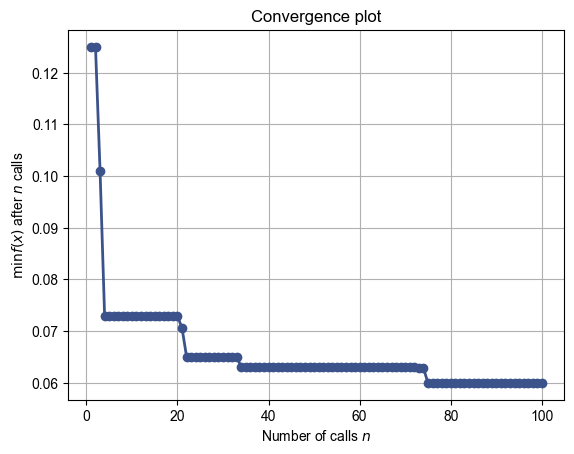

In [133]:
plot_convergence(teste_opt)


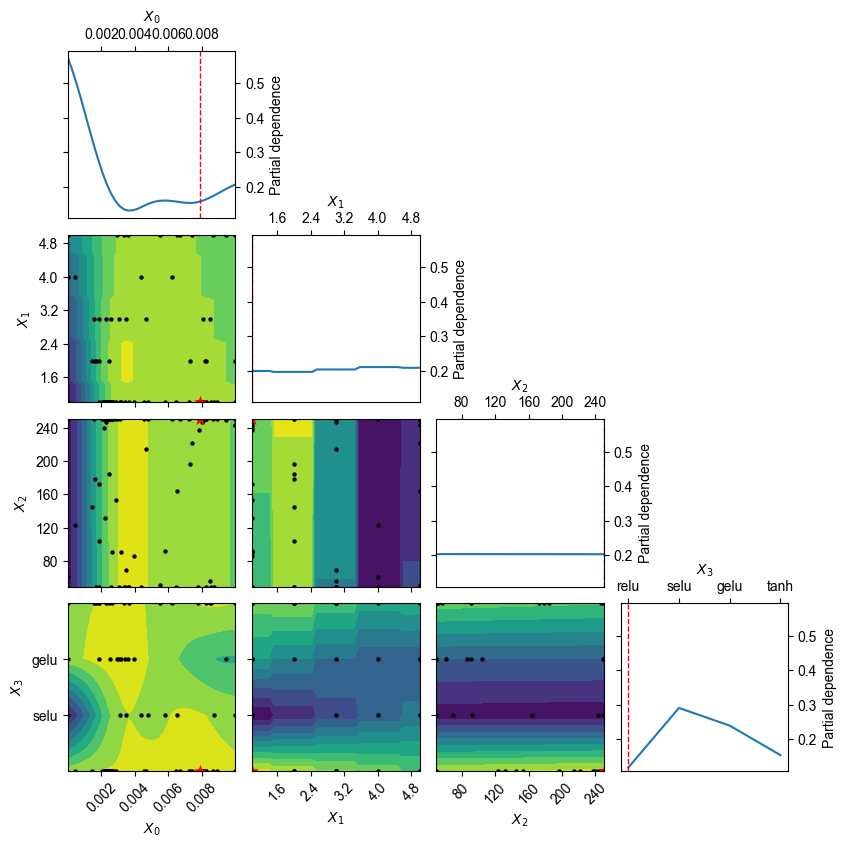

In [161]:
_ = plot_objective(teste_opt)

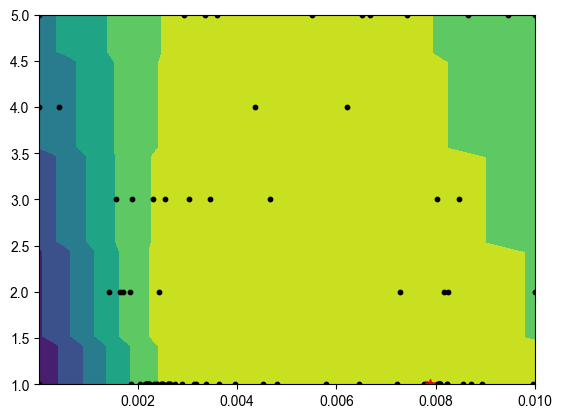

In [162]:
from skopt.plots import plot_histogram, plot_objective_2D, plot_objective

dim_names = ['Learning rate', 'Number of layers', 'Number of neurons', 'Activation']

plt.figure()
_ = plot_objective_2D(result=teste_opt,
                      dimension_identifier1=0,
                      dimension_identifier2=1, levels=5)
plt.show()

In [172]:
dim_names = ['Learning rate', 'Number of layers', 'Number of neurons', 'Activation']

opt_frame = pd.DataFrame()
opt_frame['f'] = teste_opt.func_vals
opt_frame[dim_names] = teste_opt.x_iters

,f,Learning rate,Number of layers,Number of neurons,Activation
0,0.125001,0.008477,3,57,tanh
1,0.130752,0.003447,3,70,selu
2,0.101038,0.004663,3,214,relu
3,0.072951,0.002425,2,184,tanh
4,0.118067,0.001427,2,145,relu


<AxesSubplot: >

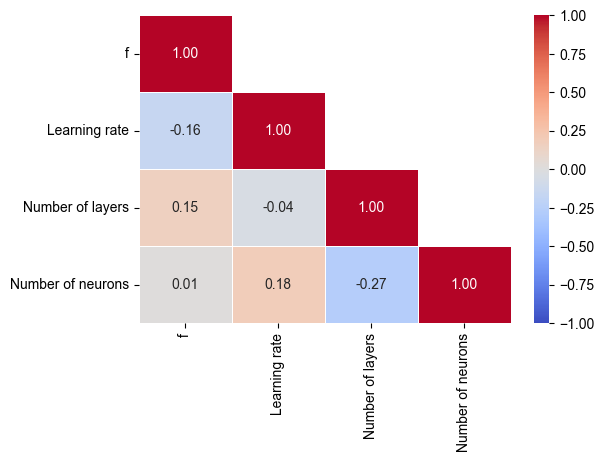

In [190]:
correlation = opt_frame.drop('Activation', axis=1).corr()

mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True

# Want diagonal elements as well
mask[np.diag_indices_from(mask)] = False

plt.figure(figsize=(6,4))
plot = sns.heatmap(correlation, mask=mask, vmin=-1, cmap= 'coolwarm',
                   annot = True, fmt=".2f", linewidths=.6)
plt.xticks(rotation = 90)
plot

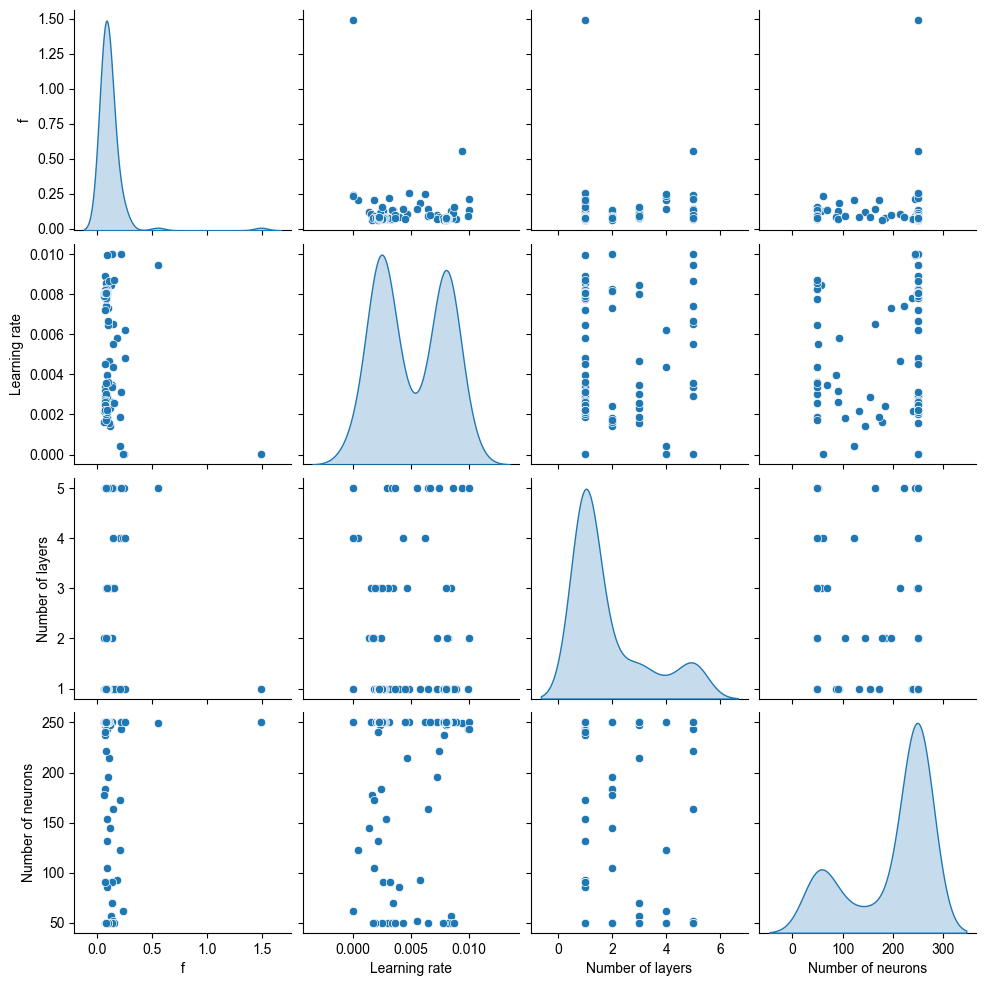

In [178]:
sns.pairplot(data=opt_frame, diag_kind='kde')

#### **OTIMIZAÇÃO USANDO GRADIENT BOOSTING MACHINE:**

****
**Data Process**

1. Read data

2. Extract data for FS < 10

3. Apply log transform 

4. Split training and test data (seed = 0)

5. Fit_transform on train + transform on test data

    * It was applied for inputs and targets
    
6. Training

****

In [62]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from skopt.utils import use_named_args
from sklearn.metrics import make_scorer

# Your custom evaluation function
def custom_evaluation_function(yv, yp):
    # Implement your custom evaluation logic here
    # Example: Accuracy
    yp = yp.reshape(1, -1)
    yv = yv.reshape(1, -1)

    yp = np.exp(out_scaler.inverse_transform(yp))
    yv = np.exp(out_scaler.inverse_transform(yv))
    return mean_squared_error(yv, yp)

custom_scorer = make_scorer(custom_evaluation_function)

# gradient boosted trees tend to do well on problems like this
reg = GradientBoostingRegressor(random_state=0)

# The list of hyper-parameters we want to optimize. For each one we define the
# bounds, the corresponding scikit-learn parameter name, as well as how to
# sample values from that dimension (`'log-uniform'` for the learning rate)
space  = [Integer(1, 200, name='n_estimators'),
          Integer(1, 25, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters
@use_named_args(space)
def objective(**params):
    reg.set_params(**params)
    scores = cross_val_score(reg, x_train_norm, y_train_norm, cv=10,
                             n_jobs=6, scoring=custom_scorer)
    print(-np.mean(scores))
    return np.mean(scores)

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0,
                     verbose = 1, initial_point_generator='lhs')

Iteration No: 1 started. Evaluating function at random point.
-4.644686151248917
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0770
Function value obtained: 4.6447
Current minimum: 4.6447
Iteration No: 2 started. Evaluating function at random point.
-0.7170091812315155
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3290
Function value obtained: 0.7170
Current minimum: 0.7170
Iteration No: 3 started. Evaluating function at random point.
-2.438753832942278
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.8151
Function value obtained: 2.4388
Current minimum: 0.7170
Iteration No: 4 started. Evaluating function at random point.
-4.62344447652862
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1910
Function value obtained: 4.6234
Current minimum: 0.7170
Iteration No: 5 started. Evaluating function at random point.
-0.7998039471013614
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.

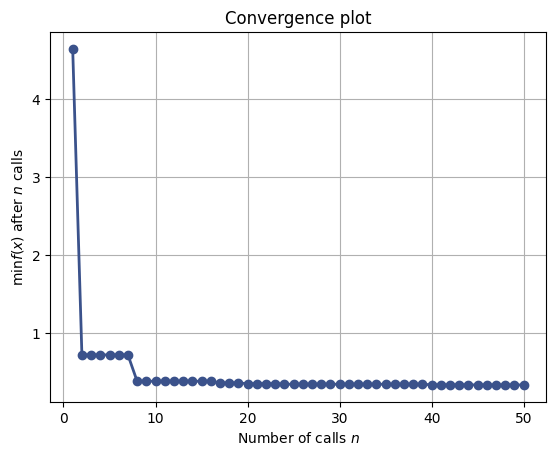

In [63]:
_ = plot_convergence(res_gp)

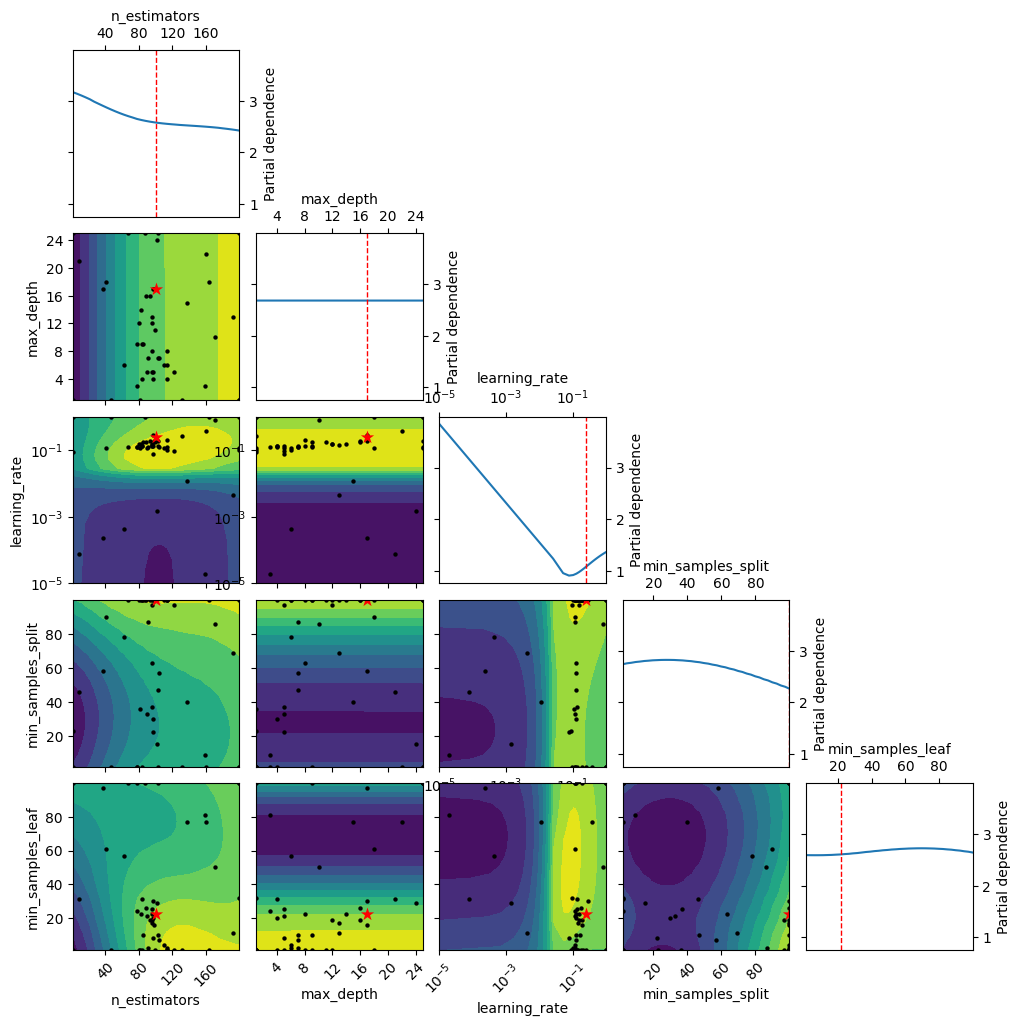

In [64]:
_ = plot_objective(res_gp)

In [65]:
print("""Best parameters:
- n_estimator=%d
- max_depth=%d
- learning_rate=%.6f
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1],
                            res_gp.x[2], res_gp.x[3],res_gp.x[4] ))

Best parameters:
- n_estimator=100
- max_depth=17
- learning_rate=0.244561
- min_samples_split=100
- min_samples_leaf=22


In [163]:
# Take best hyperparameters 
reg = GradientBoostingRegressor(n_estimators=res_gp.x[0], max_depth=res_gp.x[1],
                                learning_rate=res_gp.x[2], min_samples_split=res_gp.x[3],
                                min_samples_leaf=res_gp.x[4])

# Fit model considering normalized data:
reg = reg.fit(x_train_norm, y_train_norm)

# Evaluation considering original space: 
# Denorm + exponential!
y_pred_norm = reg.predict(x_train_norm).reshape(1, -1)
y_predicted = np.exp(out_scaler.inverse_transform(y_pred_norm))
y_expected  = np.exp(out_scaler.inverse_transform(y_train_norm)).reshape(1, -1)

r2         = r2_score(y_expected.flatten(),
                      y_predicted.flatten())

rmse       = np.sqrt(mean_squared_error(y_expected, 
                                y_predicted))

mape       = mean_absolute_percentage_error(y_expected.flatten(), 
                                            y_predicted.flatten())*100

print('Training metrics')
print(f'R² = {r2} \nRMSE = {rmse} \nMAPE = {mape}%')

c:\Users\luissantos\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training metrics
R² = 0.9924935193390869 
RMSE = 0.17699557592597398 
MAPE = 3.609586251554464%


In [162]:
# Evaluation considering original space: 
# Denorm + exponential!
y_pred_norm = reg.predict(x_test_norm).reshape(1, -1)
y_predicted = np.exp(out_scaler.inverse_transform(y_pred_norm))
y_expected  = np.exp(out_scaler.inverse_transform(y_test_norm)).reshape(1, -1)


r2         = r2_score(y_expected.flatten(),
                      y_predicted.flatten())

rmse       = np.sqrt(mean_squared_error(y_expected, 
                                y_predicted))

mape       = mean_absolute_percentage_error(y_expected.flatten(), 
                                            y_predicted.flatten())*100

print('Test metrics')
print(f'R² = {r2} \nRMSE = {rmse} \nMAPE = {mape}%')

Test metrics
R² = 0.9483491101885362 
RMSE = 0.47022724211353945 
MAPE = 13.293968310632545%


***
* **Training metrics:**
    * R² = 0.992  

    * RMSE = 0.177  

    * MAPE = 3.61%  

* **Test metrics:**
    * R² = 0.948

    * RMSE = 0.470

    * MAPE = 13.29%

* **Preeliminar conclusions:** 

    * Training MAPE is very interesting, however test MAPE is high (relative), showing a 
    overfitted model. 

    * We should try  to change the CV function to evaluate the model considering 
    the test set, or control GBM hyperparameters that adjust overffiting!

***

Feature: Specific_weight = 0.03414748697003967
Feature: Cohesion = 0.18096059616042562
Feature: Inclination = 0.2240279141041633
Feature: Height = 0.2655750835141841
Feature: Friction_angle = 0.29528891925118733


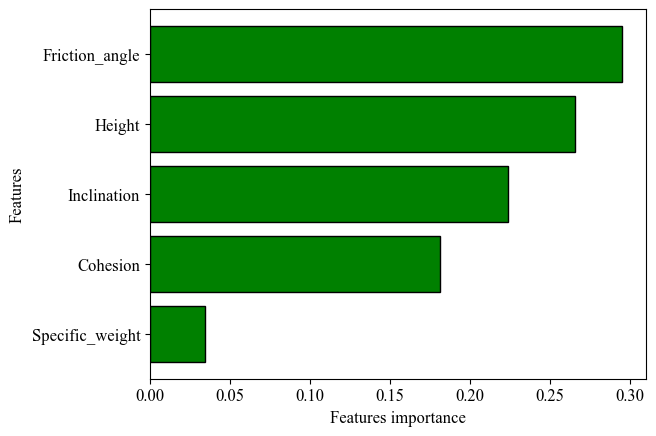

In [97]:
plt.figure()
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

for i, j in sorted(zip(list(reg.feature_importances_), inp_columns), reverse=False):
    print(f'Feature: {j} = {i}')

    plt.barh(j, i, color = 'green', edgecolor = 'k')
    _ = plt.xlabel('Features importance')
    _ = plt.ylabel('Features')


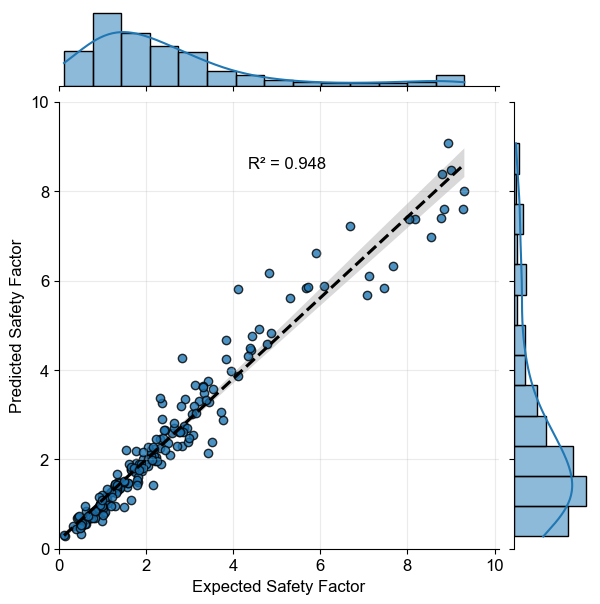

In [98]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
sns.jointplot(x = y_expected.flatten(), y = y_predicted.flatten(),
              kind='reg', scatter_kws={'edgecolor':'k'},
              line_kws={'linestyle':'--', 'color':'k'})

plt.xlabel('Expected Safety Factor')
plt.ylabel('Predicted Safety Factor')
plt.xlim([0,10.1])
plt.ylim([0,10])
plt.text(4.35, 8.5, f'R² = {r2.round(3)}')
plt.grid(alpha = 0.25)

#### **NOVA OTIMIZAÇÃO - ANN**

In [8]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations

# Supress NaN warnings, see: https://stackoverflow.com/questions/34955158/what-might-be-the-cause-of-invalid-value-encountered-in-less-equal-in-numpy
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

def cross_validation(learning_rate, num_dense_layers, num_dense_nodes, num_activation, bs=32):
    
    kf = KFold(n_splits=5)
    fold = 0
    mse  = []
    callback1 = tf.keras.callbacks.EarlyStopping(monitor='val_mse', 
                                                 patience=50, 
                                                 restore_best_weights= False, 
                                                 start_from_epoch=100)

    for train_id, test_id in kf.split(x_train, y_train):
        fold += 1
        model = create_model(learning_rate, num_dense_layers,
                             num_dense_nodes, num_activation,)  
         
        hist = model.fit(x_train[train_id], y_train[train_id], verbose = 0,
                         validation_split = 0.2, callbacks = [callback1], 
                         batch_size = bs, epochs=500)
        
        
        
        #Predict
        yp = np.exp(out_scaler.inverse_transform(model.predict(x_train[test_id], verbose = 0)))
        #Expected
        yv = np.exp(out_scaler.inverse_transform(y_train[test_id]))
        #Expected
        rmse = mean_squared_error(yv, yp)
        mse.append(rmse)

        print(f'Fold - {fold} -epochs {hist.epoch[-1]} - MSE = {rmse}')

    return np.mean(mse)
        
def fitness(dimensions):  
    learning_rate    = dimensions[0]
    num_dense_layers = dimensions[1]
    num_dense_nodes  = dimensions[2]
    num_activation   = dimensions[3]
                            
    print('########################### Nova Chamada ###########################')
    print(f'lr - {learning_rate} - HL = {num_dense_layers} - NN = {num_dense_nodes} - act = {num_activation}')
    
    mse   = cross_validation(learning_rate, num_dense_layers,num_dense_nodes, num_activation, 32)
    
    print(f'MSE - mean_folds = {mse}')

    return mse
   
def create_model(learning_rate, num_dense_layers, num_dense_nodes, activation): 

    act_func = activation

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.models.Sequential()    

    model.add(tf.keras.layers.Dense(num_dense_nodes, 
                                    input_dim = x_train.shape[1], 
                                    activation=act_func))

    for i in range(num_dense_layers-1):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(tf.keras.layers.Dense(num_dense_nodes, activation=act_func,
                                        name=name))
        
    model.add(tf.keras.layers.Dense(y_train.shape[1],
                                    activation='linear'))

    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae','mse'])
                  
    return model


In [392]:
dim_learning_rate       = Real(low=1e-5, high=1e-2)
dim_num_dense_layers    = Integer(low=1, high=8)
dim_num_dense_nodes     = Integer(low=50, high=500)
dim_activation          = Categorical(['relu','swish','tanh'])

dimensions              = [dim_learning_rate, 
                           dim_num_dense_layers, 
                           dim_num_dense_nodes,
                           dim_activation]

# Optimization: 
search_result1 = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            initial_point_generator='lhs',
                            n_initial_points=10,
                            n_jobs=4, 
                            n_calls = 100)

# 864min 38.5s

########################### Nova Chamada ###########################
lr - 0.006390187536801614 - HL = 4 - NN = 172 - act = tanh
Fold - 1 -epochs 162 - MSE = 0.39459937386359534
Fold - 2 -epochs 164 - MSE = 0.4352640849071149
Fold - 3 -epochs 165 - MSE = 0.2718178463655195
Fold - 4 -epochs 235 - MSE = 0.45170187688668995
Fold - 5 -epochs 190 - MSE = 0.1480732339801528
MSE - mean_folds = 0.34029128320061447
########################### Nova Chamada ###########################
lr - 0.0008200726141361527 - HL = 8 - NN = 125 - act = tanh
Fold - 1 -epochs 275 - MSE = 0.13076730054714336
Fold - 2 -epochs 196 - MSE = 0.18059174686522156
Fold - 3 -epochs 208 - MSE = 0.09683947890233462
Fold - 4 -epochs 154 - MSE = 0.40037509744983485
Fold - 5 -epochs 154 - MSE = 0.31370557030974144
MSE - mean_folds = 0.2244558388148552
########################### Nova Chamada ###########################
lr - 0.009273561899882075 - HL = 7 - NN = 353 - act = relu
Fold - 1 -epochs 217 - MSE = 0.07422985720946888
Fo

c:\Users\luissantos\AppData\Local\Programs\Python\Python38\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


########################### Nova Chamada ###########################
lr - 0.0007273368438146071 - HL = 7 - NN = 500 - act = swish
Fold - 1 -epochs 209 - MSE = 0.24837676944154494
Fold - 2 -epochs 294 - MSE = 0.08104882651456824
Fold - 3 -epochs 201 - MSE = 0.11306345310563354
Fold - 4 -epochs 172 - MSE = 0.295575940564464
Fold - 5 -epochs 227 - MSE = 0.13820701006974725
MSE - mean_folds = 0.17525439993919162
########################### Nova Chamada ###########################
lr - 0.0007295907779462114 - HL = 7 - NN = 500 - act = swish
Fold - 1 -epochs 222 - MSE = 0.2852168765572039
Fold - 2 -epochs 180 - MSE = 0.22192520441903654
Fold - 3 -epochs 238 - MSE = 0.09442721600615986
Fold - 4 -epochs 219 - MSE = 0.32938972390980464
Fold - 5 -epochs 368 - MSE = 0.23964063104308433
MSE - mean_folds = 0.23411993038705786
########################### Nova Chamada ###########################
lr - 0.0007289856823961066 - HL = 7 - NN = 500 - act = swish
Fold - 1 -epochs 241 - MSE = 0.10326842664095

In [393]:
# dump(search_result1, open('optimization_results_last_log.save', 'wb'))

In [12]:
search_result1 = load(open('optimization_results_last_log.save', 'rb'))
optimization_results = sorted(zip(search_result1.func_vals, search_result1.x_iters))
optimization_results


[(0.08706169020235517, [0.0007169861636172757, 6, 500, 'swish']),
 (0.08896529225055702, [0.005411908105964722, 3, 109, 'swish']),
 (0.0895306848555994, [0.007492496525732466, 2, 124, 'swish']),
 (0.09434770180500751, [0.0007174612898845354, 6, 500, 'swish']),
 (0.09598086130722963, [0.0008056024115710312, 6, 500, 'swish']),
 (0.09801268801263388, [0.0036366405754451494, 2, 174, 'swish']),
 (0.09871291830246212, [0.0031826810989209714, 3, 54, 'swish']),
 (0.09906853939145459, [0.003741523169093175, 2, 425, 'swish']),
 (0.10032372772471587, [0.005918196524644919, 1, 377, 'swish']),
 (0.10094643536135742, [0.0008088492109249706, 6, 500, 'swish']),
 (0.10279377763117396, [0.0007408481660598948, 6, 500, 'swish']),
 (0.10454613444670793, [0.0034966469100039684, 2, 50, 'swish']),
 (0.10562404137803012, [0.0007480667044944321, 6, 500, 'swish']),
 (0.10633701016469388, [0.0007277687370022614, 7, 500, 'swish']),
 (0.10645343906264611, [0.0007185729663446686, 6, 500, 'swish']),
 (0.1085289971298

<AxesSubplot: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

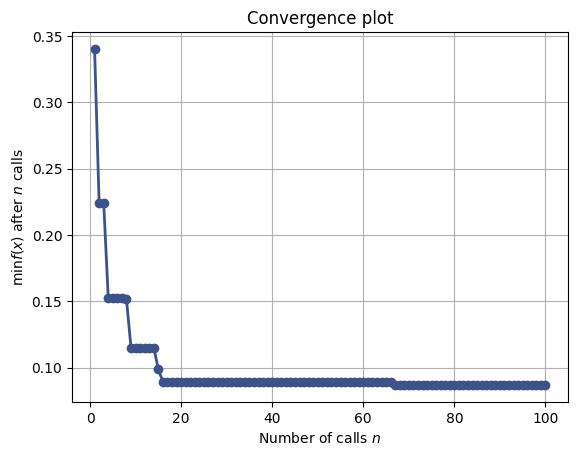

In [10]:
plot_convergence(search_result1)

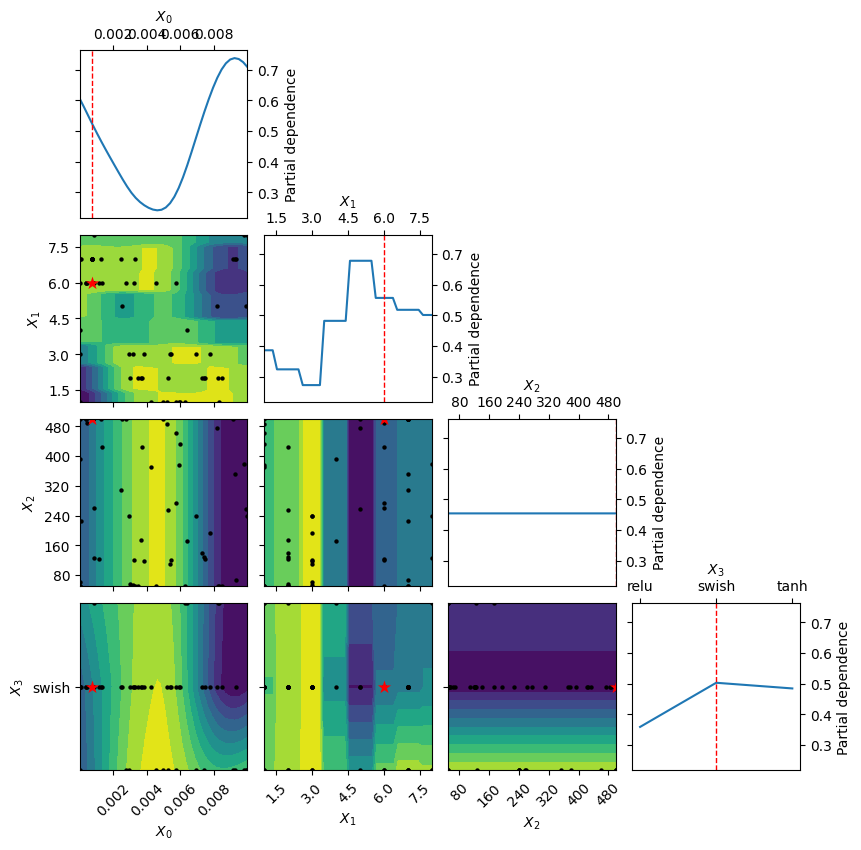

In [11]:
_ = plot_objective(search_result1)

#### **FINAL MODEL - NEURAL NETWORK EVALUATION**

In [14]:
lr = 0.0005411908105964722
hidden_layers = 3
neurons = 109
activation = 'swish'
 
model = tf.keras.models.Sequential()    
model.add(tf.keras.layers.Dense(neurons, input_dim=x_train.shape[1]))


for i in range(hidden_layers-1):
    name = 'layer_dense_{0}'.format(i+1)
    model.add(tf.keras.layers.Dense(neurons,
                                    activation=activation,
                                    name=name))
    
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

model.add(tf.keras.layers.Dense(1, activation='linear'))

model.compile(optimizer=optimizer, loss='mse',
              metrics=['mse', 'mae'])


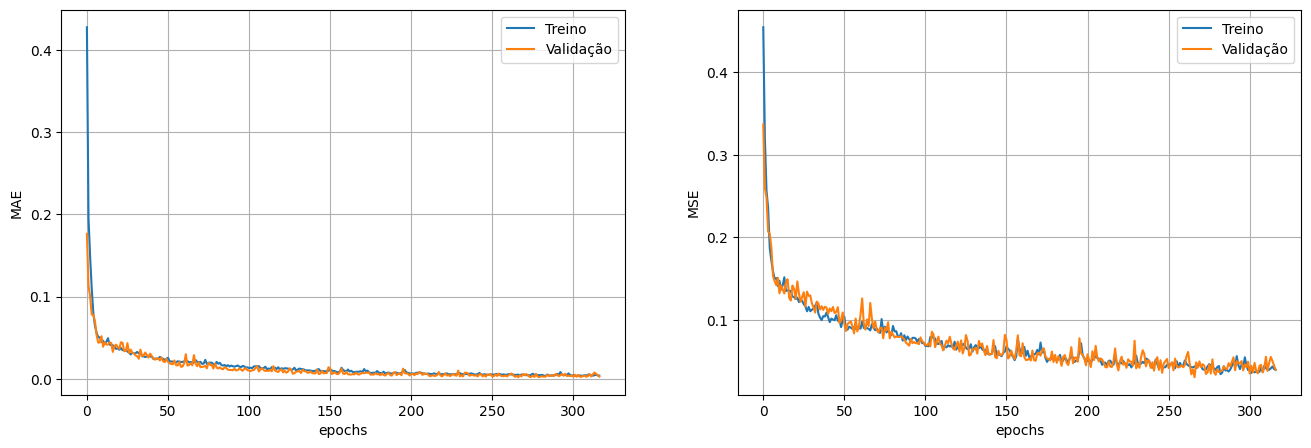

In [15]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)

history = model.fit(x_train_norm, y_train_norm, epochs = 1000, 
                    validation_split=0.1, 
                    callbacks=[early_stop],
                    batch_size=32, verbose=0)

h = history_treatment(history)


In [16]:
# Evaluation considering original space: 
# Denorm + exponential!
y_pred_norm = model.predict(x_train_norm, verbose=0).reshape(1, -1)
y_predicted = np.exp(out_scaler.inverse_transform(y_pred_norm))
y_expected  = np.exp(out_scaler.inverse_transform(y_train_norm)).reshape(1, -1)

r2  = r2_score(y_expected.flatten(), y_predicted.flatten())

rmse = mean_squared_error(y_expected, y_predicted)

mape = mean_absolute_percentage_error(y_expected.flatten(), 
                                      y_predicted.flatten())*100

print('Training metrics')
print(f'R² = {r2.round(3)} // RMSE = {rmse.round(3)} // MAPE = {mape.round(3)}%')

Training metrics
R² = 0.993 // RMSE = 0.03 // MAPE = 3.194%


In [17]:
y_pred_norm = model.predict(x_test_norm, verbose = 0).reshape(1, -1)
y_predicted = np.exp(out_scaler.inverse_transform(y_pred_norm))
y_expected  = np.exp(out_scaler.inverse_transform(y_test_norm)).reshape(1, -1)


r2  = r2_score(y_expected.flatten(), y_predicted.flatten())

rmse = mean_squared_error(y_expected, y_predicted)

mape = mean_absolute_percentage_error(y_expected.flatten(), 
                                      y_predicted.flatten())*100

print('Test metrics')
print(f'R² = {r2.round(3)} // RMSE = {rmse.round(3)} // MAPE = {mape.round(3)}%')

Test metrics
R² = 0.994 // RMSE = 0.024 // MAPE = 3.17%


***
**Conclusions**
* Training 
    * R² =  0.992 

    * RMSE = 0.032

    * MAPE = 3.355%

* Test 
    * R² = 0.994 

    * RMSE = 0.024 
    
    * MAPE = 3.498%

* **Preeliminar conclusions:** 

    * Training and test MAPE is very interesting, showing a really accurate model. 
***

In [18]:
y_pred_treino = np.exp(out_scaler.inverse_transform(model.predict(x_train_norm))).flatten()
y_real_treino = np.exp(out_scaler.inverse_transform(y_train_norm)).flatten()

y_pred_teste = np.exp(out_scaler.inverse_transform(model.predict(x_test_norm))).flatten()
y_real_teste = np.exp(out_scaler.inverse_transform(y_test_norm)).flatten()

df_error_train = pd.DataFrame()
df_error_train['y_train_pred'] = y_pred_treino
df_error_train['y_train_real'] = y_real_treino
df_error_train['train_mape'] = abs(y_pred_treino - y_real_treino) * 100 / y_real_treino
df_error_train['train_mse'] = (y_pred_treino - y_real_treino)**2 
df_error_train['train_mae'] = abs(y_pred_treino - y_real_treino)


df_error_teste = pd.DataFrame()
df_error_teste['y_test_pred'] = y_pred_teste
df_error_teste['y_test_real'] = y_real_teste
df_error_teste['teste_mape'] = abs(y_pred_teste - y_real_teste) * 100 / y_real_teste
df_error_teste['teste_mse'] = (y_pred_teste - y_real_teste)**2 
df_error_teste['teste_mae'] = abs(y_pred_teste - y_real_teste)

df_metrics_description = pd.concat([df_error_train.describe(),
                                    df_error_teste.describe()], axis=1)

6/6 [==============================] - 0s 793us/step


In [19]:
print(80*'*')
print('Training metrics')
print(df_error_train.describe().loc[['mean', 'std', 'min', 'max'], :].T.round(3))
print(80*'*')
print('Test metrics')
print(df_error_teste.describe().loc[['mean', 'std', 'min', 'max'], :].T.round(3))
print(80*'*')

********************************************************************************
Training metrics
               mean    std    min     max
y_train_pred  2.449  2.001  0.047  10.096
y_train_real  2.473  2.044  0.041   9.937
train_mape    3.194  4.471  0.000  68.382
train_mse     0.030  0.223  0.000   5.321
train_mae     0.076  0.155  0.000   2.307
********************************************************************************
Test metrics
              mean    std    min     max
y_test_pred  2.498  2.035  0.091   9.314
y_test_real  2.529  2.074  0.119   9.306
teste_mape   3.170  3.628  0.105  26.291
teste_mse    0.024  0.132  0.000   1.595
teste_mae    0.077  0.136  0.001   1.263
********************************************************************************


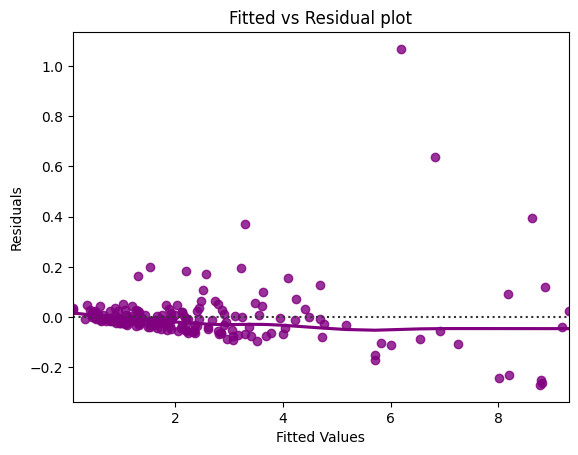

In [20]:
df_error_teste['Residuals'] = df_error_teste['y_test_pred'] - df_error_teste['y_test_real']

sns.residplot(data=df_error_teste,
              x="y_test_pred", y="teste_mae",
              color="purple", lowess=True)

plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Fitted vs Residual plot")
plt.show()

***
**Observations**

* We do not see any relevant pattern in the plot above.
* A slight incresing followed by decrease in the SF value
***

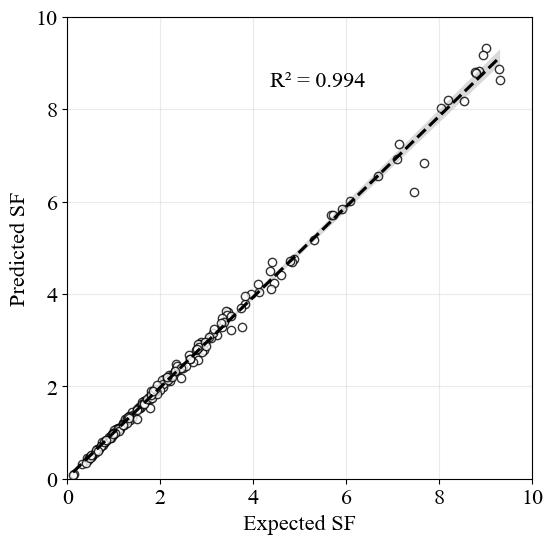

In [33]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16

# keep aspect ratio

plt.figure(figsize=(6,6))
sns.regplot(x = y_real_teste.flatten(),
            y = y_pred_teste.flatten(),
            scatter_kws={'edgecolor':'k', 'color':'w'}, line_kws={'linestyle':'--', 'color':'k'}
            )
plt.xlim(0,10)
plt.ylim(0,10)
plt.xlabel('Expected SF')
plt.ylabel('Predicted SF')
plt.text(4.35, 8.5, f'R² = {r2.round(3)}')
plt.grid(alpha = 0.25)

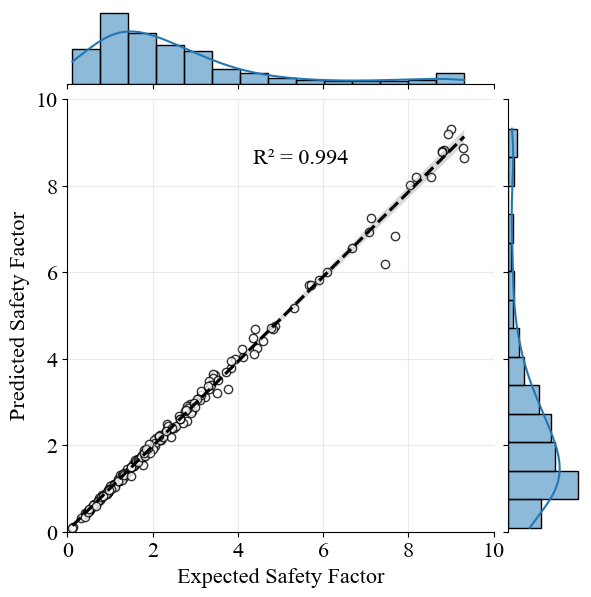

In [28]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16

sns.jointplot(x = y_real_teste.flatten(),
              y = y_pred_teste.flatten(),
              kind='reg', 
              scatter_kws={'edgecolor':'k', 'color':'w'}, line_kws={'linestyle':'--', 'color':'k'}
              )
plt.xlim(0,10)
plt.ylim(0,10)
plt.xlabel('Expected Safety Factor')
plt.ylabel('Predicted Safety Factor')
plt.text(4.35, 8.5, f'R² = {r2.round(3)}')
plt.grid(alpha = 0.25)

In [34]:
error = [100*abs((y_real_teste.flatten()[i] - y_pred_teste.flatten()[i]) /
                 (y_pred_teste.flatten()[i])) for i in range(y_pred_teste.shape[0])]

error = sorted(error)

# erros dentro dos 95% maiores
percent_error_95 = error[:int(len(error) * .95)]
# erros dentro dos 90% maiores
percent_error_90 = error[:int(len(error) * .90)]
# Erro máximo
max_error = np.round(max(error),3)
# Erros menores que 10%
less_10_error = [e for e in error if e < 10]
less_10_error_percent = round(100*(1 - len(less_10_error)/len(error)), 2)
# Erros menores que 5%
less_5_error = [e for e in error if e < 5]
less_5_error_percent = round(100*(1 - len(less_5_error)/len(error)),2)

print(f' Maximun error: {max_error}%')
print(f' {round(less_10_error_percent, 2)}% are higher than 10%')
print(f' {round(less_5_error_percent, 2)}% are higher than 5%')


 Maximun error: 35.669%
 5.73% are higher than 10%
 16.67% are higher than 5%


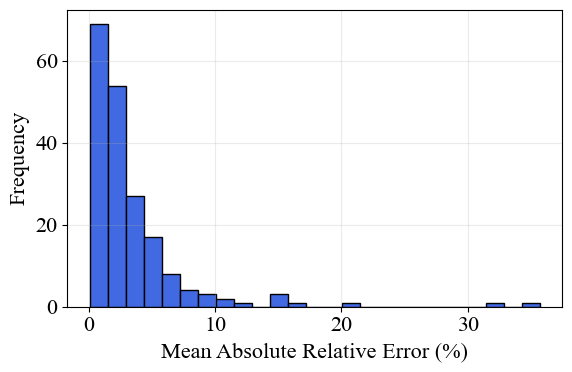

In [41]:
fig, ax = plt.subplots(1,1)
fig.set_figwidth(6)
fig.set_figheight(4)

ax.hist(error, bins = 25, edgecolor = 'k', color = 'royalblue')

# ax[1].text(x = 4, y = 20, s= f'{less_10_error}% are higher than 10%')   
# ax[2].text(x = 1.5, y = 15, s= f'{less_5_error}% are higher than 5%')

ax.set_xlabel('Mean Absolute Relative Error (%)')
ax.set_ylabel('Frequency')
plt.grid(alpha = 0.25)
plt.tight_layout()

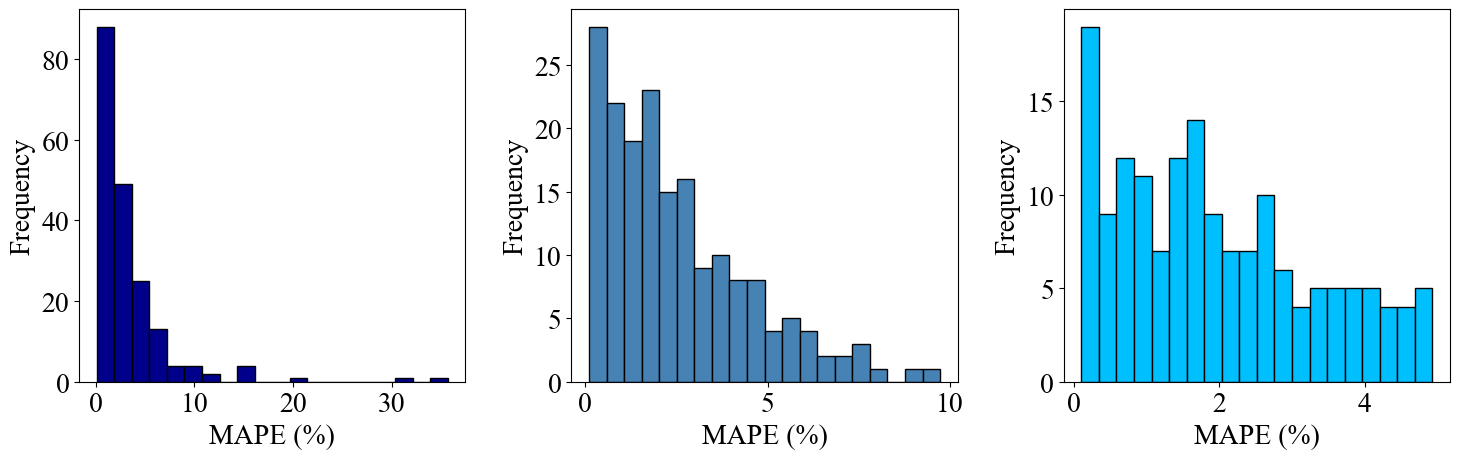

In [49]:

plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1,3)
fig.set_figwidth(15)
fig.set_figheight(5)

ax[0].hist(error, bins = 20, edgecolor = 'k', color = 'darkblue')
ax[1].hist([e for e in error if e<10], bins = 20, edgecolor = 'k', color = 'steelblue')
ax[2].hist([e for e in error if e<5], bins = 20, edgecolor = 'k', color = 'deepskyblue')


# ax[1].text(x = 4, y = 20, s= f'{less_10_error}% are higher than 10%')   
# ax[2].text(x = 1.5, y = 15, s= f'{less_5_error}% are higher than 5%')

ax[0].set_xlabel('MAPE (%)')
ax[1].set_xlabel('MAPE (%)')
ax[2].set_xlabel('MAPE (%)')
ax[0].set_ylabel('Frequency')
ax[1].set_ylabel('Frequency')
ax[2].set_ylabel('Frequency')
plt.tight_layout()

***
**Results**

* The maximum error is 28.2% 

* The average value is 3.59% with std equal to 3.58%.  

* A total of 5.21% samples reports MAPE higher than 10% 

* A total of 23.44% samples reports MAPE higher than 5%, 
i.e. 76.56% reports erros lower than 5%.
***

In [50]:
from sklearn.inspection import permutation_importance

"""
https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html
"""

# Calculate the feature importance scores
results = permutation_importance(model, x_test_norm, y_test_norm, n_repeats=100,
                                 scoring='neg_mean_absolute_percentage_error',
                                 random_state=42,)
importance = results.importances_mean

6/6 [==============================] - 0s 798us/step


Feature: Friction_angle = 3.7829925425614626
Feature: Cohesion = 3.2324250964383934
Feature: Inclination = 3.110083453297285
Feature: Height = 2.899156528344798
Feature: Specific_weight = 1.3551582531078594


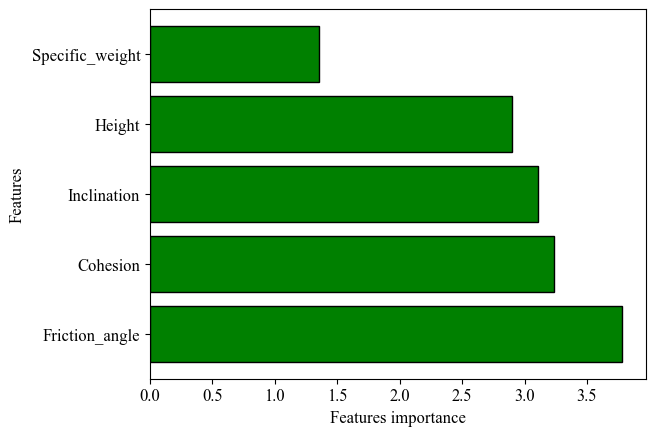

In [51]:
plt.figure()
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

for i,j in sorted(zip(importance, inp_columns), reverse=True):
    print(f'Feature: {j} = {i}')

    plt.barh(j, i, color = 'green', edgecolor = 'k')
    _ = plt.xlabel('Features importance')
    _ = plt.ylabel('Features')

### ***RETRAIN FINAL MODEL***

In [2]:
file = 'new_database_slopes.txt'
data = pd.read_csv(file)
data.columns = ['Model', 'Height','Inclination', 'Cohesion',
                'Friction_angle', 'Specific_weight', 'Safety_factor']
data.drop('Model', axis=1, inplace=True)

# ONLY USING DATA WITH FS < 10!
data = data[data['Safety_factor'] < 10]
data['Safety_factor'] = np.log(data['Safety_factor'])

inp_columns = ['Height', 'Inclination', 'Cohesion', 'Friction_angle', 'Specific_weight']
out_column = ['Safety_factor']

# Load scalers:
inp_scaler = load(open('input_scaler_log.save', 'rb'))
out_scaler = load(open('output_scaler_log.save', 'rb'))

x_train, x_test, y_train, y_test = train_test_split(data[inp_columns], 
                                                    data[out_column],
                                                    test_size = 0.2,
                                                    random_state = 0)

x_train_norm = inp_scaler.fit_transform(x_train)
x_test_norm = inp_scaler.transform(x_test)

y_train_norm = out_scaler.fit_transform(y_train)
y_test_norm = out_scaler.transform(y_test)

print('Train size:')
print(x_train_norm.shape)
print(y_train_norm.shape)
print('Test size:')
print(x_test_norm.shape)
print(y_test_norm.shape)

c:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Train size:
(764, 5)
(764, 1)
Test size:
(192, 5)
(192, 1)


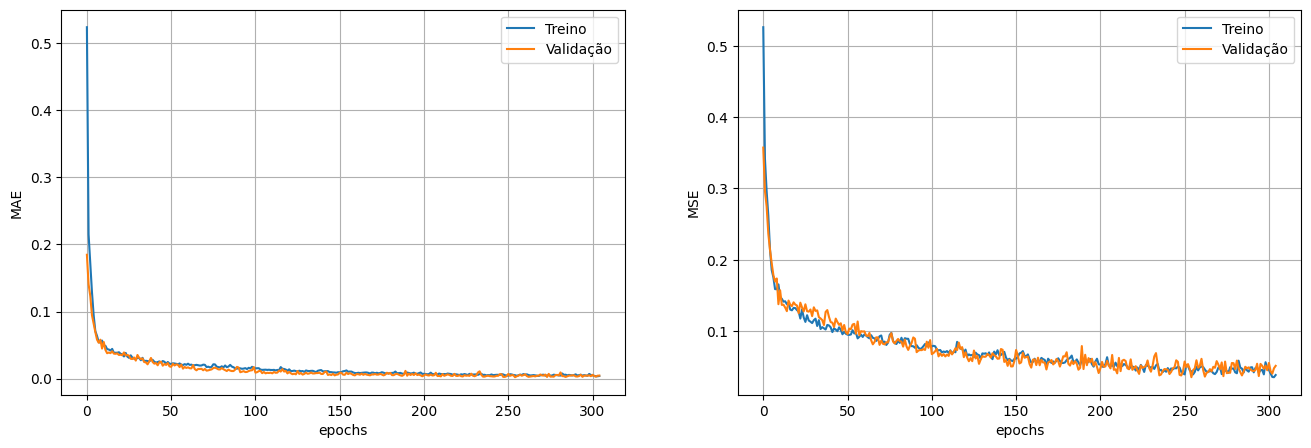

In [4]:
lr = 0.0005411908105964722
hidden_layers = 3
neurons = 109
activation = 'swish'
 
model = tf.keras.models.Sequential()    
model.add(tf.keras.layers.Dense(neurons, input_dim=x_train.shape[1]))


for i in range(hidden_layers-1):
    name = 'layer_dense_{0}'.format(i+1)
    model.add(tf.keras.layers.Dense(neurons,
                                    activation=activation,
                                    name=name))
    
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

model.add(tf.keras.layers.Dense(1, activation='linear'))

model.compile(optimizer=optimizer, loss='mse',
              metrics=['mse', 'mae'])

early_stop = tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)

history = model.fit(x_train_norm, y_train_norm, epochs = 1000, 
                    validation_split=0.1, 
                    callbacks=[early_stop],
                    batch_size=32, verbose=0)

h = history_treatment(history)


In [49]:
# get activation function of layer i
layer = model.layers[1]
activation = layer.get_config()
activation

{'name': 'layer_dense_1',
 'trainable': True,
 'dtype': 'float32',
 'units': 109,
 'activation': 'swish',
 'use_bias': True,
 'kernel_initializer': {'module': 'keras.initializers',
  'class_name': 'GlorotUniform',
  'config': {'seed': None},
  'registered_name': None},
 'bias_initializer': {'module': 'keras.initializers',
  'class_name': 'Zeros',
  'config': {},
  'registered_name': None},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [5]:
# Evaluation considering original space: 
# Denorm + exponential!
y_pred_norm = model.predict(x_train_norm, verbose=0).reshape(1, -1)
y_predicted = np.exp(out_scaler.inverse_transform(y_pred_norm))
y_expected  = np.exp(out_scaler.inverse_transform(y_train_norm)).reshape(1, -1)

r2  = r2_score(y_expected.flatten(), y_predicted.flatten())

rmse = mean_squared_error(y_expected, y_predicted)

mape = mean_absolute_percentage_error(y_expected.flatten(), 
                                      y_predicted.flatten())*100

print('Training metrics')
print(f'R² = {r2.round(3)} // RMSE = {rmse.round(3)} // MAPE = {mape.round(3)}%')

Training metrics
R² = 0.993 // RMSE = 0.028 // MAPE = 3.225%


In [6]:
y_pred_norm = model.predict(x_test_norm, verbose = 0).reshape(1, -1)
y_predicted = np.exp(out_scaler.inverse_transform(y_pred_norm))
y_expected  = np.exp(out_scaler.inverse_transform(y_test_norm)).reshape(1, -1)


r2  = r2_score(y_expected.flatten(), y_predicted.flatten())

rmse = mean_squared_error(y_expected, y_predicted)

mape = mean_absolute_percentage_error(y_expected.flatten(), 
                                      y_predicted.flatten())*100

print('Test metrics')
print(f'R² = {r2.round(3)} // RMSE = {rmse.round(3)} // MAPE = {mape.round(3)}%')

Test metrics
R² = 0.993 // RMSE = 0.03 // MAPE = 3.332%


In [7]:
# Save weights in a file:
model.save_weights('model_log_final.h5')

In [97]:
class Deploy():
    params_path = 'final_params/'
    input_scaler_path = 'final_params/input_scaler_log.save'
    input_scaler = load(open(input_scaler_path, '+rb'))
    output_scaler_path = 'final_params/output_scaler_log.save'
    output_scaler = load(open(output_scaler_path, '+rb'))

    def __init__(self):
        self.layers, self.neurons = 4, 109
        self.input_scaler = Deploy.input_scaler
        self.output_scaler = Deploy.output_scaler
        self.weights, self.bias = self.load_weights()

    def load_weights(self):
        path = Deploy.params_path
        weights, bias = [], []
        for i in range(self.layers):
            w_name = path + f'weights_{i}.txt'
            b_name = path + f'bias_{i}.txt'
            weights.append(np.loadtxt(w_name))
            bias.append(np.loadtxt(b_name))
        return weights, bias
    
    def predict(self, x):
        activation = lambda x: x * (1 / (1 + np.exp(-x)))
        x = self.input_verification(x)
        x = self.input_scaler.transform(x)
        x = np.dot(x, self.weights[0]) + self.bias[0]
        x = activation(np.dot(x, self.weights[1]) + self.bias[1])
        x = activation(np.dot(x, self.weights[2]) + self.bias[2])
        y = np.dot(x, self.weights[3]) + self.bias[3]
        y = np.exp(self.output_scaler.inverse_transform(y))
        return y
    
    def input_verification(self, x):
        l, c = x.shape
        if c != 5:
            raise ValueError(f'Expected 5 columns, got {c}')
        return x
    
model_deploy = Deploy()

c:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [98]:
model_weights = model.get_weights()
weights_ml = model_weights[::2]
bias_ml = model_weights[1::2]

# save in txt files 
for i, (w, b) in enumerate(zip(weights_ml, bias_ml)):
    np.savetxt(f'weights_{i}.txt', w)
    np.savetxt(f'bias_{i}.txt', b)

model_weights = model.get_weights()
weights_ml = model_weights[::2]
bias_ml = model_weights[1::2]

def predict(x, weights, bias, activation):
    x = np.dot(x, weights[0]) + bias[0]
    x = activation( np.dot(x, weights[1]) + bias[1])
    x = activation( np.dot(x, weights[2]) + bias[2])
    x = np.dot(x, weights[3]) + bias[3]
    return x

y_pred = predict(x_test_norm, weights_ml, bias_ml, tf.keras.activations.swish)
y_pred_ = model.predict(x_test_norm)

mae = sum(y_pred - y_pred_)
mae

6/6 [==============================] - 0s 2ms/step


array([2.02720951e-06])